In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import seaborn as sns
import pandas as pd
import math
from scipy.optimize import curve_fit

markers = itertools.cycle(['o','s','v', '+'])

import matplotlib.colors as mcolors
# get all the colors
colors_ls = list(mcolors.TABLEAU_COLORS)[:30]
colors = itertools.cycle(list(mcolors.TABLEAU_COLORS)[:30])
#%matplotlib

disorder_pbc = "../results/disorder/PBC/"
symm_pbc = "symmetries/PBC/"

# String separators and helper functions

In [2]:
# Function to convert  
def listToString(s, separator = ","): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        if isinstance(ele, (float,int)):
            str1 += "{:.3f}".format(ele) +separator 
        else:
            str1 += str(ele) +separator  
    
    # return string  
    return str1[:-1] 

In [3]:
def findDifferentElementsStrings(listOfStrings):
    different = []
    same = set()
    if len(listOfStrings) != 0:
        # create the intersection to distinguish same elements
        same = set(listOfStrings[0].split(","))
        for i in range(1,len(listOfStrings)):
            tmp = set(listOfStrings[i].split(","))
            same = same.intersection(tmp)
        # after having the intersection find the list of names to put into legend that are different
        for i in range(0, len(listOfStrings)):
            tmp = set(listOfStrings[i].split(",")) - same
            different.append(listToString(tmp))
    # return same and list of different strings in the form of tuple
    return (listToString(same), different)

findDifferentElementsStrings(["g=1,h=2", "g=1,h=3,w=4"])

('g=1', ['h=2', 'h=3,w=4'])

# Handle all the files starting from a given name given by the user and distinguished by the parameters and return the list of dataframes

In [4]:
def check_header(filename):
    with open(filename) as f:
        first = f.read(1)
        return first not in '.-0123456789'
def poisson_fit(x, lambd):
    return lambd * np.exp(-lambd * np.abs(x))
    
def laplace_fit(x, lambd,mu):
    return np.exp(-np.abs(x - mu)/lambd)/(2*lambd)

def exponential_fit(x, lambd,sigma):
    return sigma * np.exp(-lambd * np.abs(x))

def gauss_fit(x, mu, sigma):
    return np.exp(-0.5*np.power(x-mu,2)/(sigma*sigma))/(sigma*math.sqrt(2*np.pi))

def linear_fit(x,a,b):
    return a*x+b
    
def handle_all_files(directory, file_begin, columns, distinguishers, separator = "\t\t", fitfunctions = []):
    # columns is a list of tuples of column number and its name [(0:...)] etc -> 0 is an idx
    dfs = []
    # make fit before
       
    
    for filename in os.listdir(directory):
        if filename[-4:] != ".dat" or not filename.startswith(file_begin):
            continue
        # split the name and the parameters
        splitter = filename[:-4].split("_")
        # split each of the parameters 
        params = splitter[-1].split(",")
        skip = False
        
        for element in distinguishers:
            in_bucket = False
            # check elements in each element_bucket
            for bucket in element:
                if bucket in params:
                    in_bucket = True
            # if none of possible parameters from individual bucket is in params => skip
            if not in_bucket:
                skip = True
                break
                
        if not skip or len(distinguishers) == 0:
            skip_rows = 0
            # check if there is a header present already
            if check_header(directory + filename):
                skip_rows = 1
            tmp = pd.read_csv(directory + filename, sep = separator, header=None,skiprows = skip_rows, index_col = 0)
            #print(tmp)
            # check if nan's are in and skip that column if all are nans
            tmp = tmp.loc[:,tmp.notna().all(axis=0)]
            if len(columns) > 0:
                names = [column[0] for column in columns]
                numbers = [column[1] for column in columns]

                tmp = tmp[numbers[1:]]
                tmp.columns = names[1:]
            # append new df to a list of dataframes with its params   
            dfs.append((tmp, listToString(params)))
            for fitFun in fitfunctions:
                x = np.array(tmp.index)
                # always take the first column for the fit
                ydata = np.array(tmp[columns[1][0]])
                # fit curve
                popt, pcov = curve_fit(fitFun, x, ydata)
                
                fitname = "fit"
                params_fit = []
                if fitFun == linear_fit:
                    fitname ="a*x+b:"
                    params_fit.append("a=" + "{:.3f}".format(popt[0]))
                    params_fit.append("b=" + "{:.3f}".format(popt[1]))
                elif fitFun == gauss_fit:
                    fitname ="exp(-$(x-\mu)^2$/2($\sigma^2$))/($\sigma$*$\sqrt{2\pi}$):"
                    params_fit.append("$\mu$=" + "{:.3f}".format(popt[0]))
                    params_fit.append("$\sigma$=" + "{:.3f}".format(popt[1]))
                elif fitFun == exponential_fit:
                    fitname ="$\sigma$*exp(-$\lambda$x):"
                    params_fit.append("$\sigma$=" + "{:.3f}".format(popt[1]))
                    params_fit.append("$\lambda$=" + "{:.3f}".format(popt[0]))
                elif fitFun == poisson_fit:
                    fitname ="$\lambda$*exp(-$\lambda$x):"
                    params_fit.append("$\lambda$=" + "{:.3f}".format(popt[0]))
                elif fitFun == laplace_fit:
                    fitname ="exp(-|x-$\mu$|/$\lambda$)/2$\lambda$:"
                    params_fit.append("$\mu$=" + "{:.3f}".format(popt[1]))
                    params_fit.append("$\lambda$=" + "{:.3f}".format(popt[0]))
                

                fit_df = pd.DataFrame(fitFun(x, *popt))
                fit_df.index = x
                dfs.append((fit_df, fitname+listToString(params_fit,separator=":") + "," + listToString(params,separator=",")))
            
            
            
            
    #print(dfs)
    return dfs

tmp = handle_all_files(symm_pbc, "IprScaling", columns = [("h",0), ("ipr",1), ("$r_{goe}$",3)], distinguishers = [["g=0.80"]], fitfunctions = [linear_fit])
tmp

<ipython-input-4-1fe9dfbc6c59>:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(directory + filename, sep = separator, header=None,skiprows = skip_rows, index_col = 0)


[(          ipr  $r_{goe}$
  0                       
  0.2  0.342482   0.527159
  0.3  0.339794   0.530962
  0.4  0.334755   0.536120
  0.5  0.327849   0.537739
  0.6  0.318604   0.531447
  0.7  0.307980   0.528596
  0.8  0.294489   0.534366
  0.9  0.276569   0.533162
  1.0  0.255795   0.531870
  1.1  0.232230   0.532726
  1.2  0.201083   0.529202
  1.3  0.163916   0.528556
  1.4  0.122953   0.526854
  1.5  0.092691   0.525782
  1.6  0.068632   0.506860
  1.7  0.050941   0.499076
  1.8  0.037933   0.483649
  1.9  0.028574   0.462503
  2.0  0.022730   0.444705
  2.1  0.019416   0.433049
  2.2  0.017465   0.425018
  2.3  0.015833   0.422129
  2.4  0.014559   0.421237
  2.5  0.013520   0.408476
  2.6  0.012588   0.409518
  2.7  0.011801   0.403728
  2.8  0.011184   0.407329
  2.9  0.010483   0.391807
  3.0  0.010015   0.397363
  3.1  0.009507   0.392251
  3.2  0.009136   0.390386
  3.3  0.008745   0.390445
  3.4  0.008476   0.385412
  3.5  0.008697   0.376544
  3.6  0.008517   0.381464
 

# Operators plotter as a function of energies, plots all elements connecting files with parameters present in the distinguisher

In [14]:
def plot_av_operator_dfs(directory, file_begin, columns, distinguishers, operator_name, scale_x = "linear", scale_y = "linear", separator = "\t\t", fitfunctions = [], xmin = 0, xmax = 0.2, ymin = 0.01, ymax = 10):
    try:
        fitter = []
        for fitFun in fitfunctions:
            if fitFun == linear_fit:
                fitter.append("linear")
            elif fitFun == gauss_fit:
                fitter.append("gauss")
            elif fitFun == exponential_fit:
                fitter.append("exp")
            elif fitFun == poisson_fit:
                fitter.append("poisson")
            elif fitFun == laplace_fit:
                fitter.append("laplace")
        plt.clf()
        plt.cla()
        folder = 'plots/' + directory 
        if not os.path.isdir(folder):
            os.makedirs(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        # find the list of dataframes
        listOfDf = handle_all_files(directory, file_begin, columns, distinguishers, separator = separator, fitfunctions = fitfunctions)
        # create number of figures to be plotted
        fig, ax = plt.subplots(len(columns) - 1, figsize=(10,10), dpi = 100)
        
        # set labels from our list for parameters 
        labels = [item[1] for item in listOfDf]
        
        same_and_diff = findDifferentElementsStrings(labels)
        
        # set axis for it to always be a list
        axis = []
        if len(columns) > 2: # if we have many columns to plot
            axis = [ax[i] for i in range(len(columns) - 1)]
        else:
            axis = [ax]
        
        savefile = file_begin + "_" + same_and_diff[0]
        # plot
        colorki = [next(colors) for i in range(len(listOfDf))]
        #print(colorki)
        markerki = [next(markers) for i in range(len(listOfDf))]
        df_iter = 0
        for df in listOfDf:
            itr = 0
            for col in df[0].columns:
                df[0][col].plot(ax = axis[itr]
                        , linewidth=0.3
                        , marker=markerki[df_iter]
                        , markersize=1.8
                        , color = colorki[df_iter])
                itr+=1
            df_iter += 1
                
        # set the style
        for i in range(0, len(columns) - 1):
            axis[i].set(xlabel = columns[0][0],
                    ylabel = columns[i+1][0])
            if(len(listOfDf) > 1):
                #print(same_and_diff[0])
                axis[i].legend(same_and_diff[1] 
                        , frameon=False
                        , loc='best'
                        , fontsize=8.5)
            axis[i].set_yscale(scale_y)
            axis[i].set_xscale(scale_x)
            if xmin != None and xmax != None:
                axis[i].set_xlim([xmin,xmax])
            if ymin != None and ymax != None:
            #axis[i].set_xlim([-.3,0.3])
                axis[i].set_ylim([ymin, ymax])
        fig.suptitle(operator_name + " for " + same_and_diff[0], y=0.91)
        if(len(listOfDf) > 0):
        #plt.savefig(folder + savefile + ",scale_y=" + scale_y + ",scale_x=" + scale_x + listToString(fitter,",") + ".pdf")
            fits = ".png"
            if(len(fitfunctions) > 0):
                fits = "," + listToString(fitter,",") + fits
                print(fits)
            plt.savefig(folder + savefile + ",scale_y=" + scale_y + ",scale_x=" + scale_x + fits )
            plt.show()

# sigma_x                    
#plot_av_operator_dfs(symm_pbc, "SigmaX",columns = [("E/L",0), ("<n|$S_x$|n>",1)], distinguishers = [], operator_name = "<n|$S_x$|n>") 
# sigma_x prob dist
#plot_av_operator_dfs(symm_pbc, "ProbDistSigmaX",columns = [("$S^x_{nn}$", 0), ("P($S^x_{nn}$)",1)], distinguishers = [["L=18"],["g=0.80"], ["h=1.00","h=1.50"]],
#                      operator_name = "Probability distribution of $S^x_{nn}$", scale_y = 'log', fitfunctions = []) 
# sigma x repulsion
#plot_av_operator_dfs(symm_pbc, "ProbDistSpecRapSigmaX",columns = [("$S^x_{nn} - $S^x_{n-1,n-1}$", 0), ("P(r)",1)],
 #distinguishers = [["L=19","L=18", "L=17", "L=16"],["g=0.81"], ["h=1.00"]], operator_name = "("$S^x_{nn} - $S^x_{n-1,n-1}$", 0), ("P(r)",1)", scale_y = 'linear', separator = '\t')
# sigma x prob dist all sectors
#plot_av_operator_dfs(symm_pbc, "ProbDistSpecRapSigmaXAllSectors",columns = [("$S^x_{nn} - $S^x_{n-1,n-1}$", 0), ("P(r)",1)],
 #distinguishers = [], operator_name = "P(r) for all sectors", scale_y = 'linear', separator = '\t\t') 

# energy difference
#plot_av_operator_dfs(symm_pbc + "/bert/", "perturbationEnergyDiffDist",columns = [("E-E'", 0), ("P(E-E')",1)], 
                    # distinguishers = [["L=17"],["g=0.80"], ["pert=0.1450", "pert=0.0210x"], ["h=1.00"]],
                    # operator_name = "P(E-E')", scale_y = 'log', fitfunctions =[gauss_fit, exponential_fit]) 
# operators dist
#plot_av_operator_dfs(symm_pbc +"/bert/", "perturbationOperatorsDist",columns = [("$S^x_p$ - $S^x_{p+dp}$", 0), ("$P(S^x_p-S^x_{p+dp})$", 1)],
 #                    distinguishers = [["L=17"],["g=0.80"], ["h=2.80"], ["pert=0.0510", "pert=0.1450"]],
  #                   operator_name = "Probability distribution with perturbation", scale_y ="log", fitfunctions=[gauss_fit,laplace_fit]) 

#ipr scaling with h
#plot_av_operator_dfs(symm_pbc, "IprScaling",columns = [("h", 0), ("ipr", 1), ("Information entropy", 2), ("$r_{goe}$",3)], distinguishers = [["L=18"],["g=1.20","g=0.80", "g=0.40"]], operator_name = "System scaling with h")
# moments of probability sigma_x fluct
#plot_av_operator_dfs(symm_pbc, "Moments",columns = [("h", 0), ("$U_B$", 1), ("Kurtossis", 2), ("$\sigma$",3)], distinguishers = [["L=18"],["g=1.20","g=0.80"]], operator_name = "System scaling with h")

# plots columns in one plot
def plot_av_operator_cols(directory, file_begin, columns, distinguishers, operator_name, scale_x = "linear", scale_y = "linear", separator = "\t\t"):
    try:
        plt.clf()
        plt.cla()
        folder = 'plots/' + directory 
        if not os.path.isdir(folder):
            os.makedirs(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        # find the list of dataframes
        listOfDf = handle_all_files(directory, file_begin, columns, distinguishers, separator = separator)
        # create number of figures to be plotted
        fig, ax = plt.subplots(len(listOfDf), figsize=(12,10), dpi = 100)
        
        # set labels from our list for parameters 
        labels = [item[1] for item in listOfDf]
        
        same_and_diff = findDifferentElementsStrings(labels)
        
        # set axis for it to always be a list
        axis = []
        if len(listOfDf) > 1: # if we have many columns to plot
            axis = [ax[i] for i in range(len(columns) - 1)]
        else:
            axis = [ax]
        
        savefile = file_begin + "_" + same_and_diff[0]
        # plot 
        itr = 0
        for df in listOfDf:
            for col in df[0].columns:
                df[0][col].plot(ax = axis[itr]
                        , linewidth=0.55
                        , marker=next(markers)
                        , markersize=2
                        , color = next(colors))
            itr+=1
                
        # set the style
        for i in range(0, listOfDf):
            axis[i].set(title = operator_name + " with " +  columns[i+1][0] + " for " + same_and_diff[0] + "," + same_and_diff[1],
                    xlabel = columns[0][0],
                    ylabel = operator_name)
            if(len(listOfDf) > 1):
                axis[i].legend(columns[1:]
                        , frameon=False
                        , loc='best'
                        , fontsize=8)
            axis[i].set_yscale(scale_y)
            axis[i].set_xscale(scale_x)
            #axis[i].set_xlim([-0.025,0.025])
            #axis[i].set_ylim([0,200])
        plt.savefig(folder + savefile + ",scale_y=" + scale_y + ",scale_x=" + scale_x + ".pdf")
        plt.savefig(folder + savefile + ",scale_y=" + scale_y + ",scale_x=" + scale_x + ".png")
        plt.show()  

## Plot only distributions in different files

In [15]:
def plot_distribution(directory, file_begin, columns, distinguishers, distribution_name, column_num = [], separator = "\t\t"):
    try:
        folder = 'plots/' + directory 
        if not os.path.isdir(folder):
            os.makedirs(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        # find the list of dataframes
        listOfDf = handle_all_files(directory, file_begin,columns, distinguishers, column_num, separator)
        labels = [item[1] for item in listOfDf]
        same_and_diff = findDifferentElementsStrings(labels)
        
        # plot 
        counter = 0
        for df in listOfDf:
            savefile = file_begin + "_" + same_and_diff[0] + "," + labels[counter]
            fig, ax = plt.subplots(len(columns) - 1, figsize=(12,8), dpi = 120) 
            axis = []
            if len(columns) > 2: # if we have many columns to plot
                axis = [ax[i] for i in range(len(columns) - 1)]
            else:
                axis = [ax]
            
            step = 0.01
            _min = np.min(df[0].index)
            _max = np.max(df[0].index)
            new_ticks = [_min + step * i for i in range(0, int((_max-_min)/step) + 1)]
            print(new_ticks)
            itr = 0
            for col in df[0].columns:      

                df[0][col].plot.bar(ax = axis[itr], rot=15, color = next(colors))
                axis[itr].set(title = distribution_name + " for " + same_and_diff[0] + "," + same_and_diff[1][counter]
                            ,xlabel = col
                            ,ylabel = distribution_name)
                #axis[itr].get_legend().remove()
                #(same_and_diff
                #            , frameon=False
                #            , loc='best'
                #            , fontsize=8)
                axis[itr].set_xticks(np.interp(new_ticks, df[0].index, np.arange(df[0].size)))
                axis[itr].set_xticklabels(new_ticks)
                itr+=1
            counter+=1
            plt.savefig(folder + savefile + ".pdf")
            plt.savefig(folder + savefile + ".png")
            plt.show()


#plot_distribution(symm_pbc, "ProbDistSpecRapSigmaX", columns = ["P(|r|)", "<n + 1|$S_x$|n + 1> - <n|$S_x$|n>"], distinguishers = [], distribution_name= "P(|r|)", separator = "\t")

# PLOT HEATMAP

In [16]:
def plot_heat_map(directory, file_begin, columns, distinguishers, operator_name, separator = "\t\t"):
    try:
        folder = 'plots/' + directory 
        if not os.path.isdir(folder):
            os.makedirs(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        
        # find the list of dataframes
        listOfDf = handle_all_files(directory, file_begin,columns, distinguishers, separator)
        labels = [item[1] for item in listOfDf]
        same_and_diff = findDifferentElementsStrings(labels)
            
        # plot 
        counter = 0
        for df in listOfDf:
            fig, ax = plt.subplots(figsize=(12,10), dpi = 100)
            savefile = operator_name + "_" + same_and_diff[0] + "," + labels[counter]
            df[0]["index"] = df[0].index
            cols = df[0].columns
            #print(cols)
            pivotted = df[0].pivot(cols[2], cols[0], cols[1])
            # PLOT 
            z = np.array(df[0].loc[:,cols[1]])
            y = np.array(df[0].loc[:,cols[0]])
            x = np.array(df[0].loc[:,cols[2]])
            #print(z)
            mini = np.min(z)
            maxi = np.max(z)
            print(mini,maxi)
            sns.heatmap(pivotted,cmap='coolwarm',vmin=np.min(z), vmax=np.max(z))
            #sns.heatmap(pivotted,cmap='coolwarm',vmin=np.min(z), vmax=np.max(z))
            if(len(columns) == 3):
                plt.xlabel(columns[0][0])
                plt.ylabel(columns[1][0])
            #ax.set_zscale([0.35,0.535])
            plt.title(operator_name + " for " + labels[counter])
            plt.savefig(folder + savefile + ".png")
            plt.savefig(folder + savefile + ".pdf")
            plt.show()
            counter +=1
    
                  


# ipr parameter sweeep
plot_heat_map(symm_pbc, "IprScalingMap",columns = [("g",0), ("h",1),("ipr",2)], distinguishers = [["L=15"]], operator_name = "ipr") 

In [66]:
def plotKurtosisFromDF(directory,name_of_file_start, x_distinguisher, Ls):
    
    fig, ax = plt.subplots(figsize=(15,15))
    labels = []
    for L in Ls:
        pd = filesToDataFrame(directory, name_of_file_start, L, x_distinguisher)
        values = []
        kurto = []
        if not pd.empty:
            labels.append("L=" + str(L))
                     
            kurtos = pd.kurtosis(axis = 0)
            #print(kurtos)
            kurto = [a for a in kurtos]
            values = [float(x.split("=")[-1]) for x in kurtos.index]                 # list of possible x_disting values
            #print(kurto)
            #print(values)
            # print(len(kurto))
            # print(len(values))
            order = np.argsort(values)
            
            
            ax.plot(np.array(values)[order], np.array(kurto)[order],
                    linewidth = 1.5,
                    marker = next(markers),
                    markersize = 4
                )
    #print(labels)       
    ax.set(title = "kurtosis of $\sigma _x$ probability distribution"
    , xlabel = x_distinguisher
    , ylabel = "kurtosis(P($\sigma _x$))")
    ax.legend(labels
      , frameon=False
      , loc='best'
      , fontsize=8)
    ax.set_xlim([0,4.5])
    #ax.set_ylim([0,4])
    plt.savefig(directory + "kurtosis_" + name_of_file_start + ".png")
    plt.show()

plotKurtosisFromDF(directory + "./", "ProbDistSigmaX", "w", [12])

NameError: name 'directory' is not defined

In [7]:
def plotBinderFromDF(directory,name_of_file_start, x_distinguisher, Ls):
    
    fig, ax = plt.subplots(figsize=(15,15))
    labels = []
    for L in Ls:
        pd = filesToDataFrame(directory, name_of_file_start, L, x_distinguisher)
        values = []
        binder = []
        if not pd.empty:
            labels.append("L=" + str(L))
            
            square_pd = pd.apply(np.square, axis =1)
            fourth_pd=square_pd.apply(np.square, axis = 1)
            
            #print(square_pd)
            
            fourth_mean = [fourth_pd[a].mean() for a in fourth_pd.columns]
            square_mean = [square_pd[a].mean() for a in square_pd.columns]

            
            for i in range(len(square_mean)):
                binder.append(1 - fourth_mean[i]/(3*square_mean[i]))
            ##print(binder)
            values = [float(x.split("=")[-1]) for x in pd.columns]                 # list of possible x_disting values
            
            order = np.argsort(values)
            #print(kurto)
            #print(values)
            # print(len(kurto))
            # print(len(values))
            ax.plot(np.array(values)[order], np.array(binder)[order],
                    linewidth = 1.5,
                    marker = next(markers),
                    markersize = 4
            )
    #print(labels)       
    ax.set(title = "Binder cumulant of $\sigma _x$ probability distribution"
    , xlabel = x_distinguisher
    , ylabel = "U(P($\sigma _x$))")
    ax.legend(labels
      , frameon=False
      , loc='best'
      , fontsize=8)
    ax.set_xlim([-0,4.5])
    #ax.set_ylim([-80,10])
    plt.savefig(directory + "BinderCumulant_" + name_of_file_start + ".png")
    plt.show()

plotBinderFromDF(directory + "./", "ProbDistSigmaX", "w", [12])

NameError: name 'directory' is not defined

<ipython-input-4-1fe9dfbc6c59>:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(directory + filename, sep = separator, header=None,skiprows = skip_rows, index_col = 0)


,gauss,exp.png


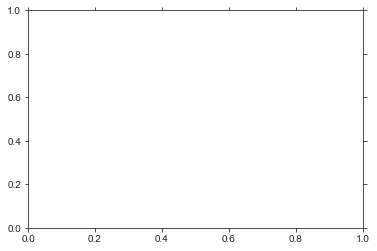

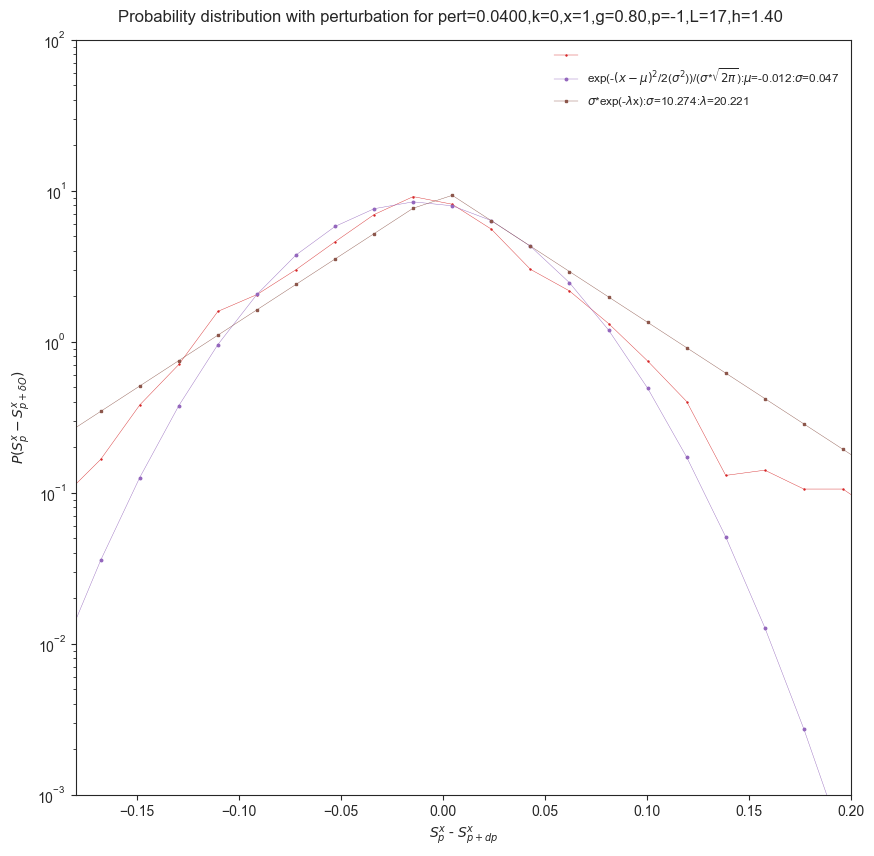

<ipython-input-4-1fe9dfbc6c59>:51: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(directory + filename, sep = separator, header=None,skiprows = skip_rows, index_col = 0)


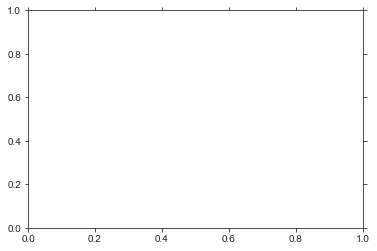

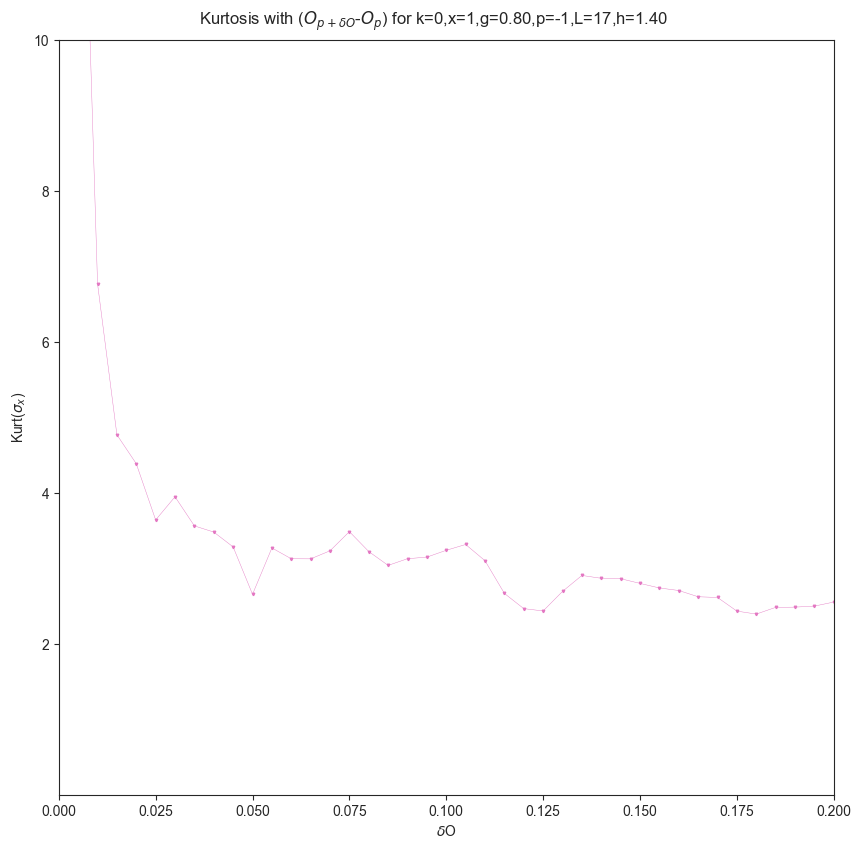

In [43]:
# OPERATOR PERT L=16
plot_av_operator_dfs(symm_pbc + "/bert/", "perturbationOperatorsDist",columns = [("$S^x_p$ - $S^x_{p+dp}$", 0), ("$P(S^x_p-S^x_{p+\delta O})$", 1)],
                     distinguishers = [["L=17"],["g=0.80"], ["h=1.40"], ["pert=0.0400"]],
                     operator_name = "Probability distribution with perturbation", scale_y ="log", fitfunctions=[gauss_fit,exponential_fit],
                     xmin = -0.18, ymin = 0.001, ymax =100) 

#gaussianity
plot_av_operator_dfs(symm_pbc + "/bert/", "PertGaussianity",columns = [("$\delta$O", 0), ("Kurt($\sigma_x$)", 1)],
                     distinguishers = [["L=17"],["g=0.80"], ["h=1.40"]],
                     operator_name = "Kurtosis with ($O_{p+\delta O}$-$O_p$)", scale_y ="linear", fitfunctions=[]) 